# Example 5.9 (An ellipse format chart for overtime hours)

In [1]:
import pathlib
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Ellipse

In [2]:
def load_data() -> pd.DataFrame:
    fpth = pathlib.Path(r'..\..\data\Table5.8.xlsx')
    return pd.read_excel(fpth)

In [3]:
df = load_data()

In [4]:
# X is n x p = 16 x 2.
X = df.iloc[:, 0:2].to_numpy()
n, p = X.shape

In [5]:
xbar = np.mean(X, axis=0).reshape(p, 1)
S = np.cov(X.T, ddof=1)

In [6]:
alpha = 0.01
crit = scipy.stats.chi2(df=p).ppf(q=1-alpha)

Compute ${\left(\textbf{x} - \bar{\textbf{x}}\right)}^{\prime} \textbf{S}^{-1} {\left(\textbf{x} - \bar{\textbf{x}}\right)}$

In [7]:
Sinv = np.linalg.inv(S)
stat_dist = lambda x: (x.reshape(1,p) - xbar.T) @ Sinv @ (x.reshape(p,1) - xbar)
dist = np.array([stat_dist(X[i,:]).flatten() for i in range(X.shape[0])])

How many values are larger than $\chi_{p=2}^{2}\left(0.01\right)$?

In [8]:
print(f'There are {(dist > crit).sum()} observations larger than {crit:.2f}.')

There are 1 observations larger than 9.21.


In [9]:
def plot_confidence_ellipse(df: pd.DataFrame, alpha: float):
    df = df.copy()
    xbar = np.mean(df, axis=0).to_numpy()
    n, p = df.shape
    S = np.cov(df.T)

    eigenvalues, eigenvectors = np.linalg.eig(S)
    max_idx, min_idx = np.argmax(eigenvalues), np.argmin(eigenvalues)
    lmbda1, lmbda2 = eigenvalues[max_idx], eigenvalues[min_idx]
    e1, e2 = eigenvectors[:, max_idx].copy(), eigenvectors[:, min_idx].copy()

    chi2_val = scipy.stats.chi2(df=p).ppf(1 - alpha)

    # Restrict major-axis eigenvector to Quadrants 1 and 2.
    if np.all(e1 < 0) | ((e1[0] > 0) & (e1[1] < 0)):
        e1 = e1*(-1)

    ell_width = np.sqrt(lmbda1)*np.sqrt(chi2_val)
    ell_height = np.sqrt(lmbda2)*np.sqrt(chi2_val)
    # Use adjacent angle for cos based on quadrant 1 or 2.
    ell_angle = np.arccos(e1[1] if e1[0] > 0 else e1[0])*(180/np.pi)

    plt.figure()
    ax = plt.gca()
    ellipse = Ellipse(xy=xbar,
                      width=2*ell_width,
                      height=2*ell_height,
                      angle=ell_angle,
                      fill=False)
    ax.add_patch(ellipse)
    for i in [-1, 1]:
        plt.quiver(xbar[0],
                xbar[1],
                e1[0] * ell_width * i,
                e1[1] * ell_width * i,
                angles='xy',
                scale_units='xy',
                scale=1
                )
        plt.quiver(xbar[0],
                xbar[1],
                e2[0] * ell_height * i,
                e2[1] * ell_height * i,
                angles='xy',
                scale_units='xy',
                scale=1)
    return plt, ax

Text(0, 0.5, 'Extraordinary Event Overtime')

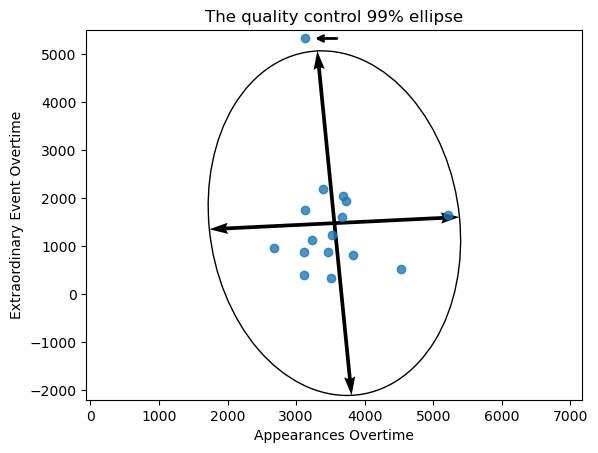

In [10]:
my_plot, ax = plot_confidence_ellipse(df.iloc[:,[0,1]], alpha)
my_plot.scatter(X[:,0], X[:,1], alpha=0.8)
plt.annotate(
    '',
    xy=tuple(X[X[:,1] > 5000].squeeze() + [100, 0]),
    xytext=tuple(X[X[:,1] > 5000].squeeze()+[500, 0]),
    arrowprops=dict(facecolor='black', arrowstyle='->',linewidth=2)
)
my_plot.ylim([-2200, 5500])
ax.set_aspect(aspect=0.7, adjustable='datalim')
ax.set_title('The quality control 99% ellipse')
my_plot.xlabel('Appearances Overtime')
my_plot.ylabel('Extraordinary Event Overtime')


In [11]:
cl = xbar[1] + np.array([-1, 1]) * (3 * np.sqrt(S[1,1]))

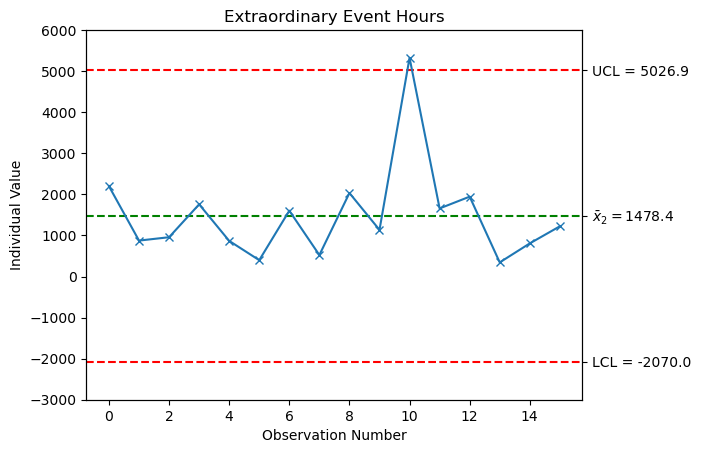

In [12]:
plt.figure()
ax = plt.gca()
plt.axhline(y=cl[0], color='r', linestyle='--')
plt.axhline(y=xbar[1].item(), color='g', linestyle='--')
plt.axhline(y=cl[1], color='r', linestyle='--')
plt.plot(X[:,1], marker='x')
plt.ylim([-3000, 6000])
plt.title('Extraordinary Event Hours')
plt.xlabel('Observation Number')
plt.ylabel('Individual Value')
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim()) 
ax2.set_yticks([cl[0], xbar[1].item(), cl[1]])
ax2.set_yticklabels([f'LCL = {cl[0]:.1f}', f'$\\bar{{x}}_{2} = {xbar[1].item():.1f}$', f'UCL = {cl[1]:.1f}'])
plt.show()